In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from maddeb.Deblender import Deblend
from maddeb.utils import listdir_fullpath
from maddeb.extraction import extract_cutouts

import numpy as np
import os

import matplotlib.pyplot as plt

import btk
import btk.plot_utils
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions
import astropy.table

import tensorflow as tf
import tensorflow_probability as tfp
tf.get_logger().setLevel('ERROR')

from maddeb.utils import CustomSampling

2023-01-04 14:11:16.276268: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2023-01-04 14:11:16.276506: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import seaborn as sns
sns.set_theme(style={"axes.grid": True,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'white',
                     'image.cmap': 'viridis',})

# Generate the blended scene

In [3]:
COSMOS_CATALOG_PATHS = "/sps/lsst/users/bbiswas/OneDegSq_snr_10.fits"

stamp_size = 41
min_number = 8
max_number = 15
batch_size = 2
maxshift = 15
num_repetations = 15
catalog = btk.catalog.CatsimCatalog.from_file(COSMOS_CATALOG_PATHS)
survey = btk.survey.get_surveys("LSST")
seed = 13
run_name = "test_run_catsim"

linear_norm_coeff = [1000, 5000, 10000, 10000, 10000, 10000]

sampling_function = btk.sampling_functions.DefaultSampling(
    max_number=max_number, min_number=min_number, max_shift=maxshift, stamp_size=stamp_size, seed=seed
)

draw_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    survey,
    batch_size=batch_size,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="all",
    verbose=False,
    seed=seed,
)

In [4]:
blend = next(draw_generator)

blend['blend_list'][0]['x_peak']

np.shape(blend['blend_images'][0])

Generating blends for LSST survey:   0%|          | 0/2 [00:00<?, ?it/s]

(6, 205, 205)

input_image


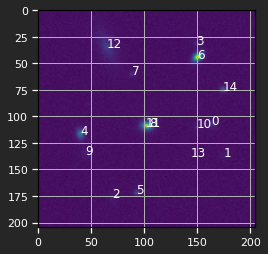

In [5]:
print("input_image")
plt.imshow(blend['blend_images'][0, 2])
for i in range(len(blend['blend_list'][0])):
    plt.text(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], str(i))

input_image


/tmp/ipykernel_9772/2459567947.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  bar = fig.colorbar(im1, ax=ax)


<Figure size 720x720 with 0 Axes>

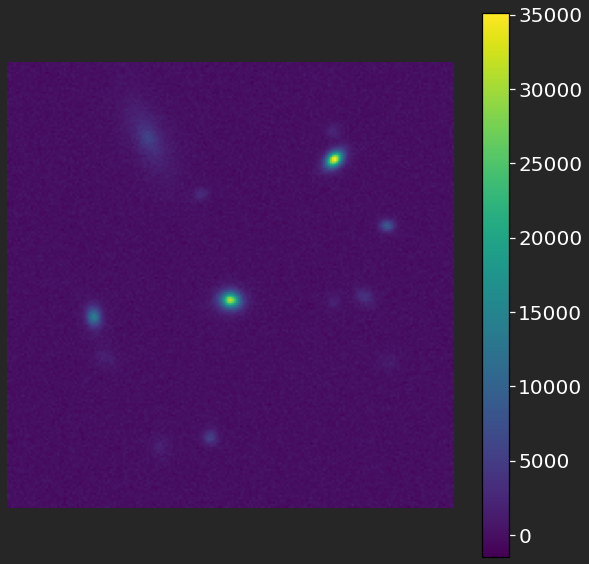

In [6]:
fig = plt.figure(figsize=(10,10))
print("input_image")
fig=plt.figure(figsize=(10,10))
ax=fig.gca()
im1 = ax.imshow(blend['blend_images'][0, 2])
#for i in range(len(blend['blend_list'][0])):
#    plt.scatter(blend['blend_list'][0]['x_peak'][i], 
#                blend['blend_list'][0]['y_peak'][i], marker="x", c="r")
    #plt.text(blend['blend_list'][0]['x_peak'][i]-1, blend['blend_list'][0]['y_peak'][i]-1, str(i), c='black', fontsize=15)
bar = fig.colorbar(im1, ax=ax)
bar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.savefig("input field")


# Initialize the Deblender

In [7]:
tf.get_logger().setLevel('ERROR')

detected_positions = []
for i in range(len(blend['blend_list'][0])):
    detected_positions.append([blend['blend_list'][0]['y_peak'][i], blend['blend_list'][0]['x_peak'][i]])

deb = Deblend(blend['blend_images'][0], 
              detected_positions,
              latent_dim=16, 
              num_components=len(blend['blend_list'][0]), 
              use_likelihood=True, 
              linear_norm_coeff=linear_norm_coeff,
              max_iter=500)

2023-01-04 14:11:46.812898: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2023-01-04 14:11:46.813111: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-04 14:11:46.813287: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jns-bbiswas.cc.in2p3.fr): /proc/driver/nvidia/version does not exist
2023-01-04 14:11:46.814682: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-04 14:11:46.8

0.001


2023-01-04 14:11:56.051226: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# Test run Debvader

In [8]:
deb.run_debvader()

In [9]:
# fig, ax = plt.subplots(len(blend['blend_list'][0]), 3, figsize=(5*3,5*len(blend['blend_list'][0])))

# for i in range(len(blend['blend_list'][0])):

#     #print("image number: " + str(i))
#     image_index = i
#     im1 = ax[i, 0].imshow(crop_image(blend['isolated_images'][0][i], detected_positions[i], 9))
#     cbar = fig.colorbar(im1, ax=ax[i, 0])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 0].set_title("ground truth")
#     ax[i, 0].scatter(22, 22, c="r", marker="x")

#     im2 = ax[i, 1].imshow(deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im2, ax=ax[i, 1])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 1].set_title("predicted")
    
#     im3 = ax[i, 2].imshow(crop_image(blend['isolated_images'][0][i], detected_positions[i], 9) - deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im3, ax=ax[i, 2])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 2].set_title("actual - predicted")
    
# plt.show()

/tmp/ipykernel_9772/4083717891.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar =fig.colorbar(im1, ax=ax)


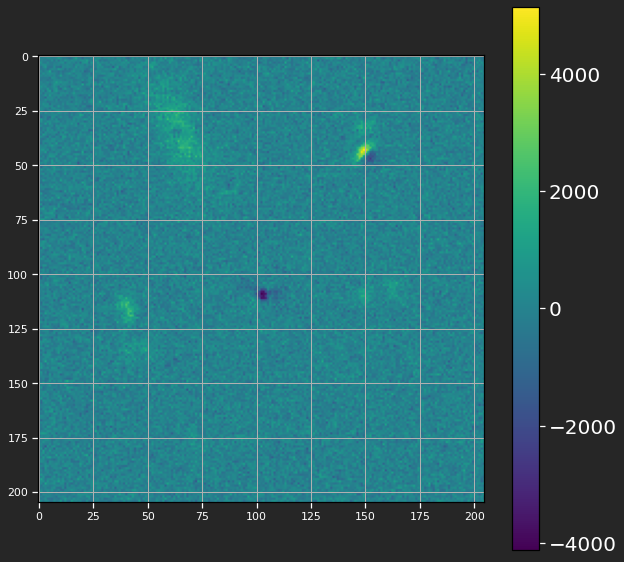

In [10]:
# Residual after debvader run

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
padding_infos = deb.get_padding_infos()
residual = deb.compute_residual(np.transpose(blend['blend_images'][0], axes=[1, 2, 0]), use_scatter_and_sub=True).numpy()
#residual = np.transpose(deb.postage_stamp, 
im1 = ax.imshow(residual[:, :, 3])
cbar =fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.savefig("residual")

In [11]:
# fig, ax = plt.subplots(len(blend['blend_list'][0]), 2, figsize=(5*2,5*len(blend['blend_list'][0])))

# for i in range(len(blend['blend_list'][0])):

#     im1 = ax[i, 0].imshow(extract_cutouts(blend['isolated_images'][0][i], [detected_positions[i]], distances_to_center=False, cutout_size=45)[0][0, :, :, 2])
#     cbar = fig.colorbar(im1, ax=ax[i, 0])
#     cbar.ax.tick_params(labelsize=20)
#     ax[i, 0].set_title("ground truth", fontsize=20)
#     ax[i, 0].scatter(22, 22, c="r", marker="x")
#     ax[i, 0].axis('off')


#     im2 = ax[i, 1].imshow(deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im2, ax=ax[i, 1])
#     cbar.ax.tick_params(labelsize=20)
#     ax[i, 1].set_title("predicted", fontsize=20)
#     ax[i, 1].axis('off')

# plt.show()

# Run MADNESS

In [15]:
import tensorflow_addons as tfa
tf.config.run_functions_eagerly(False)
tf.config.run_functions_eagerly(False)
convergence_criterion = tfp.optimizer.convergence_criteria.LossNotDecreasing(
    atol=0.000001 * 45 * 45 * len(blend) * 3, min_num_steps=100, window_size=20
)
convergence_criterion = tfp.optimizer.convergence_criteria.SuccessiveGradientsAreUncorrelated(min_num_steps=100, window_size=20)
# convergence_criterion = None
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1., decay_steps=25, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
#optimizer=tfa.optimizers.AdaBelief(learning_rate=lr_scheduler)

deb(convergence_criterion, optimizer=optimizer, use_debvader=True, compute_sig_dynamically=False)



Using encoder for initial point

--- Starting gradient descent in the latent space ---
Maximum number of iterations: 500
Number of Galaxies: 15
Dimensions of latent space: 16


142994.547
-16547.0312
138087.781
-9889.51074
133298.828
-6944.54199
132678.484
-5230.7207
133488.047
-4086.61084
133722.219
-3287.13599
133244.953
-2684.86279
132328.891
-2268.7041
131399.312
-2011.75049
130721.531
-1881.85986
130477.656
-1834.59863
130572.312
-1794.02979
130652.062
-1784.65674
130533.297
-1779.95361
130200.656
-1746.71484
129808.867
-1715.32373
129360.227
-1719.93555
129015.922
-1707.79785
128877.297
-1668.6228
128866.719
-1619.40015
128856.281
-1571.72266
128747
-1531.16479
128624.234
-1499.03394
128520.711
-1466.21729
128432.727
-1432.75208
128344.391
-1401.04468
128264.859
-1379.87305
128178.672
-1365.9259
128097.805
-1352.198
128031.844
-1328.88208
128005.797
-1295.91504
128020.172
-1266.96313
128021.516
-1241.90625
127975.852
-1217.05334
127900.656
-1197.45837
127847.977
-1187.98877
127837.75
-1173.11938
127835.625
-1145.20752
127823.906
-1115.10706
127806.766
-1092.64429
127796.984
-1071.66284
127786.344
-1048.47632
127758.844
-1029.04224
127727.375
-1016.75562

--- Gradient descent complete ---

Time taken for gradient descent: 59.48198056221008


tf.Tensor(
[159541.58  147977.3   140243.38  137909.2   137574.66  137009.36
 135929.81  134597.6   133411.06  132603.39  132312.25  132366.34
 132436.72  132313.25  131947.38  131524.19  131080.16  130723.72
 130545.92  130486.12  130428.    130278.164 130123.266 129986.93
 129865.48  129745.44  129644.734 129544.6   129450.    129360.73
 129301.71  129287.13  129263.42  129192.91  129098.12  129035.97
 129010.87  128980.836 128939.016 128899.41  128868.65  128834.82
 128787.88  128744.13  128715.78  128691.99  128659.34  128620.18
 128591.97  128574.51  128553.68  128527.836 128499.36  128477.85
 128459.05  128438.44  128418.51  128400.516 128382.805 128363.95
 128345.11  128330.516 128318.234 128305.66  128292.55  128277.84
 128262.16  128247.89  128234.5   128221.77  128210.52  128200.47
 128189.04  128174.74  128159.43  128145.94  128132.82  128121.35
 128117.81  128114.49  128112.62  128109.71  128106.086 128101.59
 128093.43  128087.49  128081.734 128073.63  128067.625 128061.98

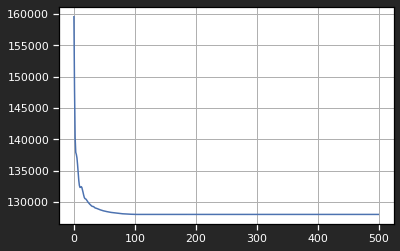

In [16]:
print(deb.results)
plt.plot(deb.results);

/tmp/ipykernel_9772/651321632.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im1, ax=ax[i, 0])
/tmp/ipykernel_9772/651321632.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im1, ax=ax[i, 1])
/tmp/ipykernel_9772/651321632.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im2, ax=ax[i, 2])
/tmp/ipykernel_9772/651321632.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb

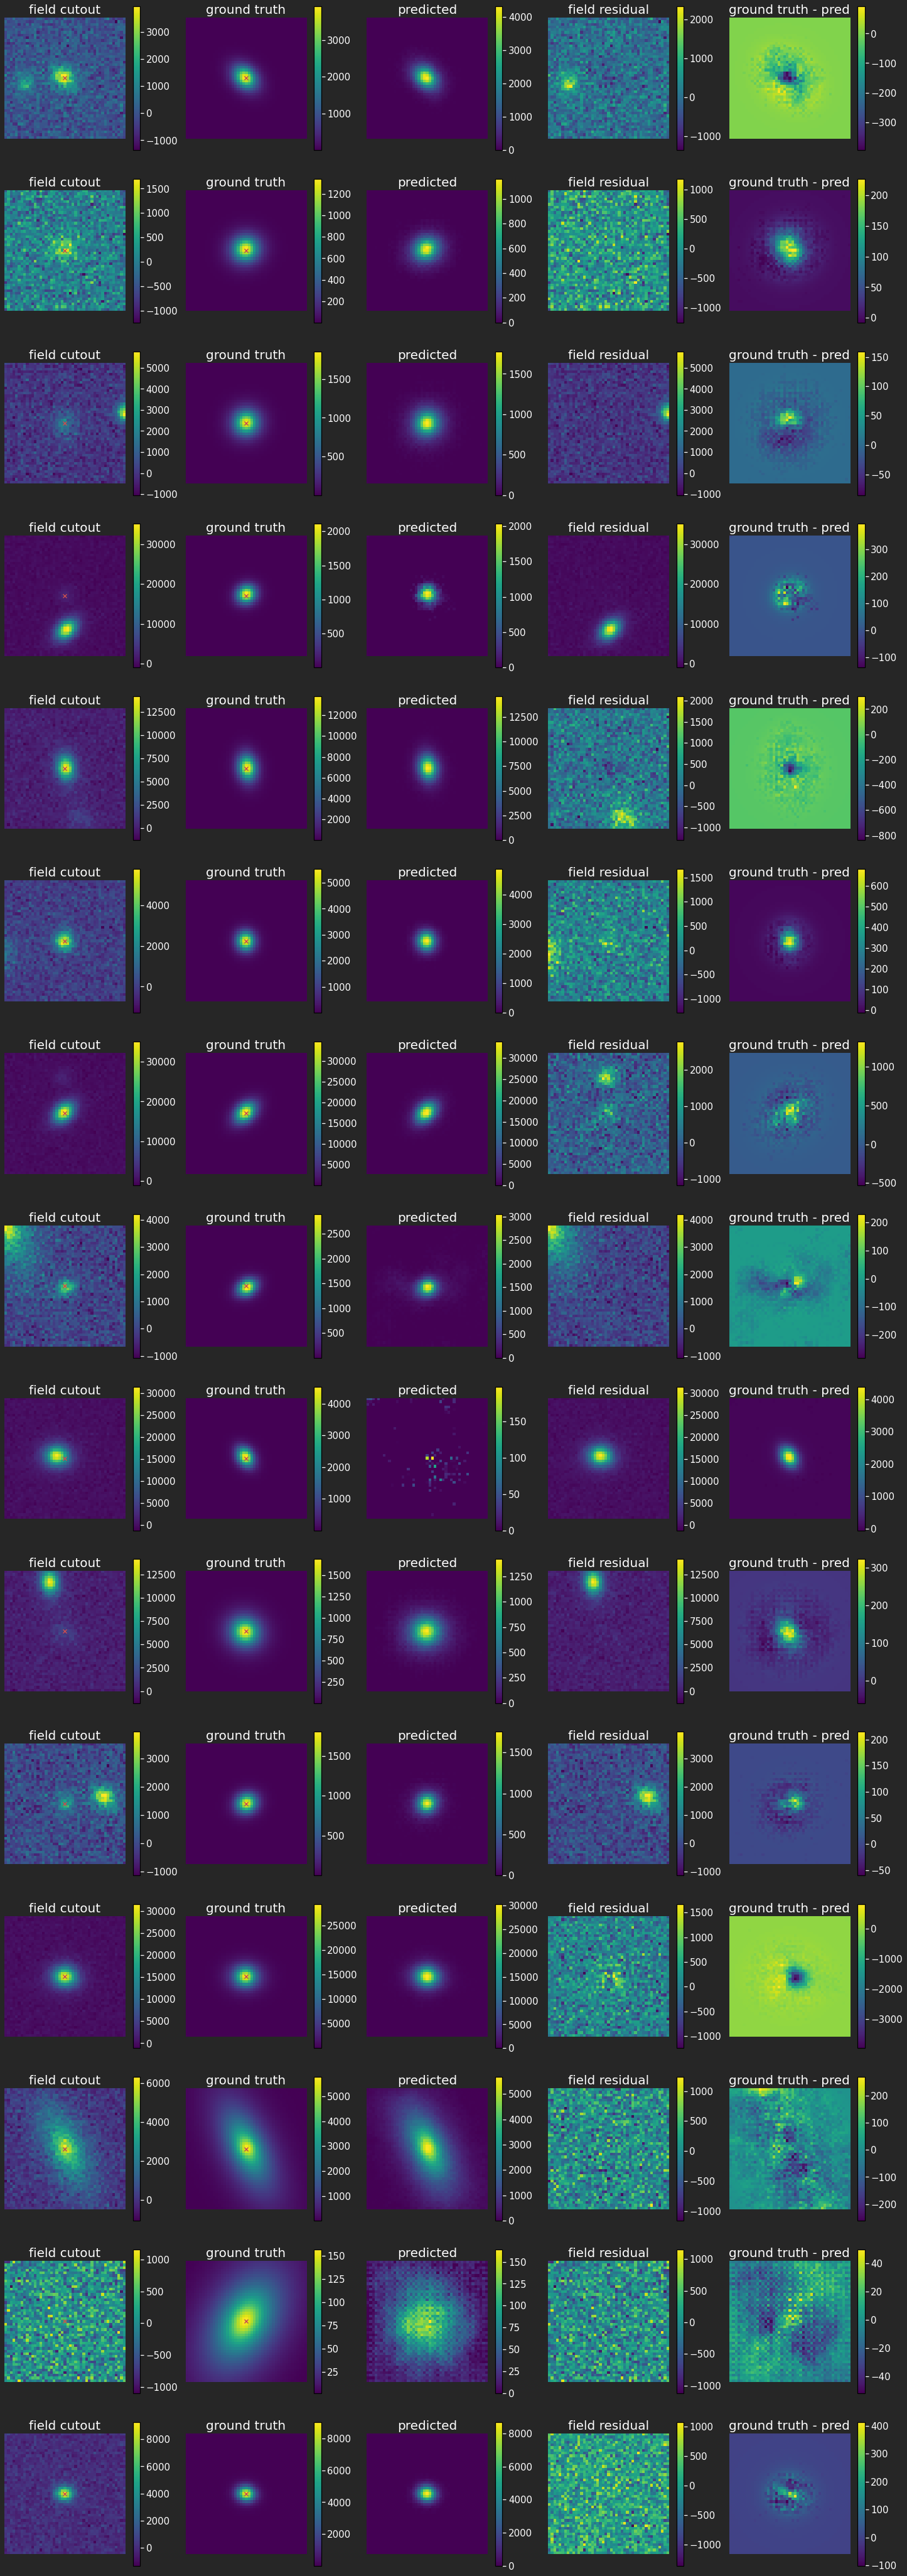

In [17]:
fig, ax = plt.subplots(len(blend['blend_list'][0]), 5, figsize=(5*5,5*len(blend['blend_list'][0])))

for i in range(len(blend['blend_list'][0])):

    #print("image number: " + str(i))
    #image_index = shuffled_indices[i]
    field_cutout_r_band = extract_cutouts(blend['blend_images'][0], [detected_positions[i]], distances_to_center=False, channel_last=False, cutout_size=45)[0][0,:, :, 2]
    galaxy_cutout_r_band = extract_cutouts(blend['isolated_images'][0][i], [detected_positions[i]], distances_to_center=False, cutout_size=45)[0][0, :, :, 2]
    
    im1 = ax[i, 0].imshow(field_cutout_r_band)
    cbar = fig.colorbar(im1, ax=ax[i, 0])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 0].set_title("field cutout", fontsize=20)
    ax[i, 0].scatter(22, 22, c="r", marker="x")
    ax[i, 0].axis('off')

    im1 = ax[i, 1].imshow(galaxy_cutout_r_band)
    cbar = fig.colorbar(im1, ax=ax[i, 1])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 1].set_title("ground truth", fontsize=20)
    ax[i, 1].scatter(22, 22, c="r", marker="x")
    ax[i, 1].axis('off')


    im2 = ax[i, 2].imshow(deb.components[i][:, :, 2])
    cbar = fig.colorbar(im2, ax=ax[i, 2])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 2].set_title("predicted", fontsize=20)
    ax[i, 2].axis('off')
    
    im3 = ax[i, 3].imshow(field_cutout_r_band - deb.components[i][:, :, 2])
    cbar = fig.colorbar(im3, ax=ax[i, 3])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 3].set_title("field residual", fontsize=20)
    ax[i, 3].axis('off')

    
    im3 = ax[i, 4].imshow(galaxy_cutout_r_band - deb.components[i][:, :, 2])
    cbar = fig.colorbar(im3, ax=ax[i, 4])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 4].set_title("ground truth - pred", fontsize=20)
    ax[i, 4].axis('off')

plt.savefig("MAP_predictions")
plt.show()

In [18]:
# fig, ax = plt.subplots(1, len(blend['blend_list'][0]), figsize=(5*len(blend['blend_list'][0]), 5*1))
# for i in range(len(blend['blend_list'][0])):

#     #print("image number: " + str(i))
#     #image_index = shuffled_indices[i]

#     im2 = ax[i].imshow(deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im2, ax=ax[i])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i].axis("off")
#     #ax[i].set_title("predicted")
# plt.savefig("predictions")

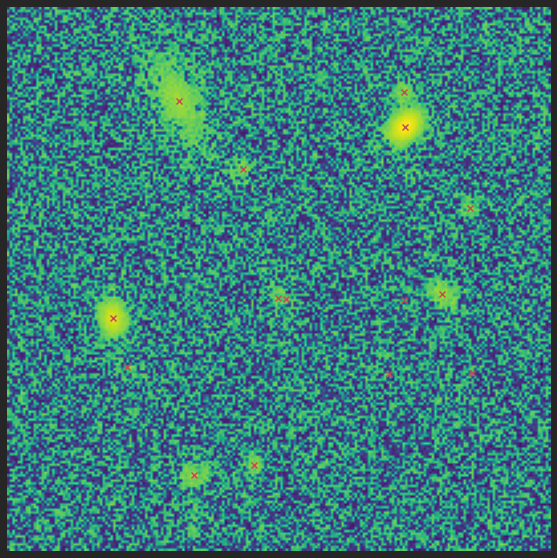

In [19]:
# This is just to make the blends more visible

sns.set_theme(style={"axes.grid": False,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'white',
                     'image.cmap': 'viridis',})

fig = plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(np.arcsinh(blend['blend_images'][0][0]))
for i in range(len(blend['blend_list'][0])):
    plt.scatter(blend['blend_list'][0]['x_peak'][i], 
                blend['blend_list'][0]['y_peak'][i], marker="x", c="r")

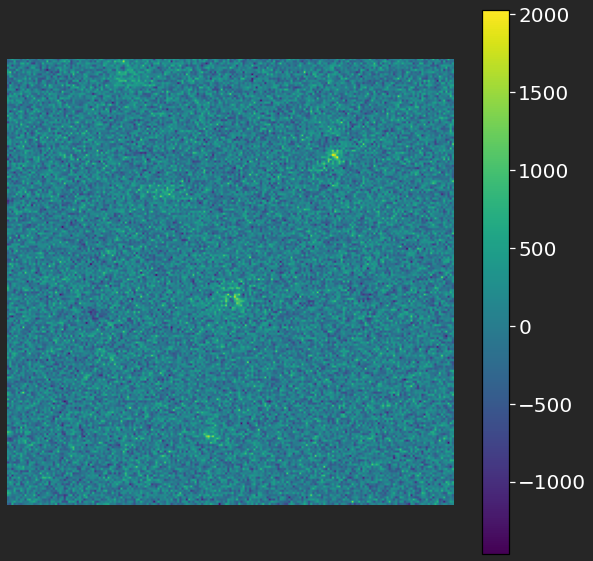

In [24]:
# Residual after MADNESS run
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
tf.config.run_functions_eagerly(True)

padding_infos = deb.get_padding_infos()
residual = deb.compute_residual(np.transpose(blend['blend_images'][0], axes=[1, 2, 0]), use_scatter_and_sub=True).numpy()
#residual = np.transpose(deb.postage_stamp, 
im1 = ax.imshow(residual[:, :, 2])
cbar =fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.savefig("residual")

#for i in range(len(blend['blend_list'][0])):
    #plt.scatter(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], marker="x", linewidths=.5, s=120, c="r")

##### sns.set_theme(style={"axes.grid": True,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'white',
                     'image.cmap': 'viridis',})

plt.figure(figsize=(8,3))
residual_flattened = residual[:, :, 0].flatten()
print(np.shape(residual_flattened))
plt.hist(residual_flattened, bins=50)
plt.xticks(fontsize=15)
plt.yticks([])

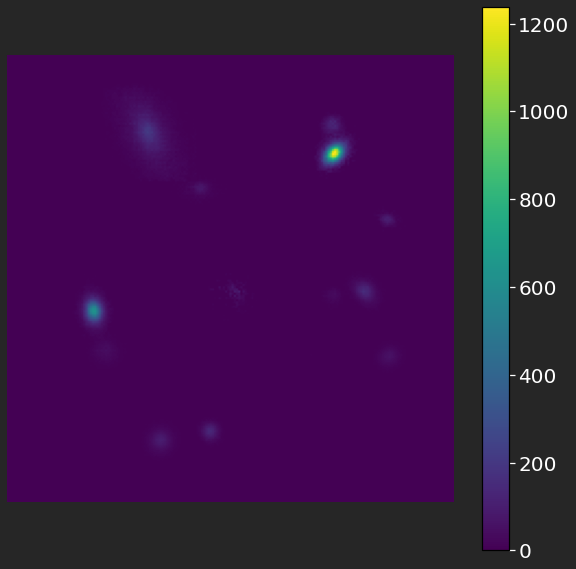

In [21]:
sns.set_theme(style={"axes.grid": False,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'white',
                     'image.cmap': 'viridis',})
predicted_field = blend['blend_images'][0] - np.transpose(residual, axes=[2, 0, 1])
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
im1 = ax.imshow(predicted_field[0, :, :])
cbar =fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.show();

In [22]:
from maddeb.metrics import compute_reconstruction_metrics
from maddeb.extraction import extract_cutouts

In [23]:
field_size = np.shape(blend['isolated_images'][0][i])[1]

In [25]:
field_image=blend['blend_images'][0]

In [26]:
cutouts, list_idx = extract_cutouts(field_image=blend['blend_images'][0], pos=np.array(detected_positions), cutout_size=45, channel_last=False)

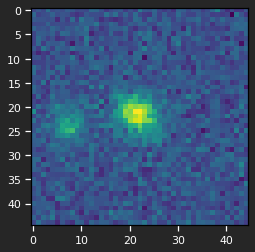

In [27]:
plt.imshow(cutouts[0][:, :, 2])

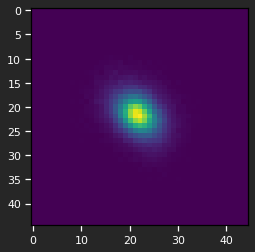

In [28]:
plt.imshow(deb.components[0][:, :, 2])

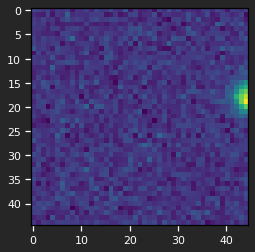

In [29]:
plt.imshow(cutouts[2][:, :, 2]-deb.components[2][:, :, 2])

In [30]:
results=compute_reconstruction_metrics(deb.components, cutouts)

TypeError: Cannot interpret 'tf.float32' as a data type

In [31]:
plt.hist(results["mse"]);

NameError: name 'results' is not defined

In [32]:
plt.hist(results["psnr"]);

NameError: name 'results' is not defined

In [33]:
plt.hist(results["ssim"]);

NameError: name 'results' is not defined